In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
from scipy.interpolate import interp1d

import numpy as np
#from ler.rates import LeR
import json
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.cosmology import LambdaCDM
cosmoLambdaCDM = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
cosmo = cosmoLambdaCDM

from astropy.cosmology import Planck18

from scipy.integrate import quad, dblquad
from scipy.stats import gengamma, rayleigh
from scipy.special import gamma

from numba import njit, jit
from ler.utils import rejection_sample
from scipy.interpolate import interp1d

from ler.utils import interpolator_from_pickle

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.epl_shear_solver import caustics_epl_shear

# For sampling from caustic
from shapely.geometry import Polygon
import pointpats

In [2]:
# get json file
with open('../lensed_param_detectable.json', 'r') as f:
    lensed_param = json.load(f)

In [4]:
lensed_param.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'n_images', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'opt_snr_net', 'L1', 'H1', 'V1'])

In [13]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution

lens = LensGalaxyParameterDistribution(
    npool=6,
    source_priors=dict(
        merger_rate_density='merger_rate_density_bbh_popI_II_oguri2018',
        source_frame_masses='binary_masses_BBH_popI_II_powerlaw_gaussian',
    ),
    source_priors_params=dict(
        merger_rate_density={'R0': 25e-09, 'b2': 1.6, 'b3': 2.0, 'b4': 30},
        source_frame_masses={'mminbh': 4.98, 'mmaxbh': 112.5, 'alpha': 3.78, 'mu_g': 32.27, 'sigma_g': 3.88, 'lambda_peak': 0.03, 'delta_m': 4.8, 'beta': 0.81},
    ),
    lens_functions=dict(
        strong_lensing_condition='rjs_with_cross_section',
        optical_depth='optical_depth_SIE_hemanta',
    ),
    lens_priors=dict(
        velocity_dispersion='velocity_dispersion_ewoud',
        axis_ratio='axis_ratio_rayleigh',
    ),
    lens_priors_params=dict(
        velocity_dispersion=None,
        axis_ratio=dict(q_min=0.2, q_max=1.),
    ),
)

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_2.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_7.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be loaded from ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_2.pickle
z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_6.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_6.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_6.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
velocity_dispersion_ewoud interpolator will be load

In [14]:
from ler.lens_galaxy_population import phi_q2_ellipticity, phi_cut_SIE

size = 10
zs = lens.sample_source_redshift_sl(size=size)
zl = lens.sample_lens_redshift(zs=zs)
sigma = lens.sample_velocity_dispersion(size=size, zl=zl)
q = lens.sample_axis_ratio(sigma)
phi = lens.sample_axis_rotation_angle(size=size)
e1, e2 = phi_q2_ellipticity(phi, q)
gamma = lens.sample_mass_density_spectral_index(size=size)
gamma1, gamma2 = lens.sample_shear(size=size)

phi_cut = phi_cut_SIE(q)

In [7]:
max(e1)

0.3108303711471001

In [4]:
from ler.lens_galaxy_population import phi_cut_epl_shear

In [5]:
test = phi_cut_epl_shear(e1, e2, gamma, gamma1, gamma2)

In [4]:
def phi_cut_epl_shear(e1, e2, gamma, gamma1, gamma2):
    kwargs_lens = [
                {
                    "theta_E": 1.,
                    "e1": e1,
                    "e2": e2,
                    "gamma": gamma,
                    "center_x": 0.0,
                    "center_y": 0.0,
                },
                {
                    "gamma1": gamma1,
                    "gamma2": gamma2,
                    "ra_0": 0,
                    "dec_0": 0,
                },
            ]

    caustic_double_points = caustics_epl_shear(
                kwargs_lens, return_which="double", maginf=-5000
            )
    caustic_double = Polygon(caustic_double_points.T)
    return np.round(caustic_double.area/np.pi, 3)

In [15]:
cut = []
for i in range(size):
    cut.append(phi_cut_epl_shear(e1[i], e2[i], gamma[i], gamma1[i], gamma2[i]))

In [33]:
#plt.hist(np.random.normal(loc=0., scale=0.05,size=10000), bins=50, density=True)
gamma1, gamma2 = lens.sample_shear(size=10000)

In [29]:
for i in range(100000):
    g1 = []
    g2 = []
    try:
        test = phi_cut_epl_shear(0.036, -0.018, 2.85, gamma1[i], gamma2[i])
    except:
        g1.append(gamma1[i])
        g2.append(gamma2[i])
        

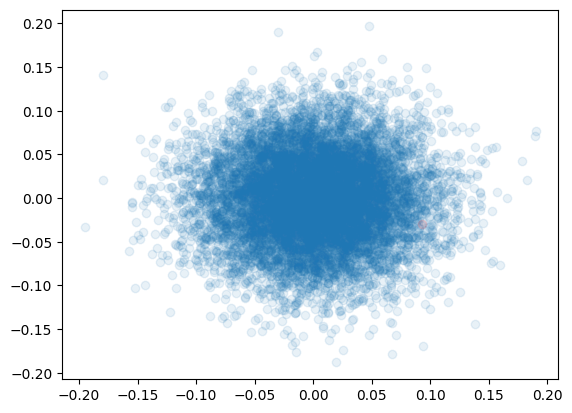

In [37]:
plt.plot(gamma1, gamma2, 'o', alpha=0.1)
plt.plot(0.09302973080191373, -0.029833840860278404, 'o', alpha=0.1, color='red')

In [83]:
kwargs_lens = [
            {
                "theta_E": 1.,
                "e1": 0.036,
                "e2": -0.018,
                "gamma": 2.8,
                "center_x": 0.0,
                "center_y": 0.0,
            },
            {
                "gamma1": 0.09302973080191373,
                "gamma2": -0.029833840860278404,
                "ra_0": 0,
                "dec_0": 0,
            },
        ]

caustic_double_points = caustics_epl_shear(
            kwargs_lens, return_which="double", maginf=-100, num_th=500,
        )

In [84]:
# omit nan in caustic_double_points
# caustic_double_points[0]
idx = ~np.isnan(caustic_double_points[0])
caustic_double_points0 = caustic_double_points[0][idx]
caustic_double_points1 = caustic_double_points[1][idx]
caustic_double_points = np.array([caustic_double_points0, caustic_double_points1])

In [85]:
caustic_double = Polygon(caustic_double_points.T)
area = caustic_double.area

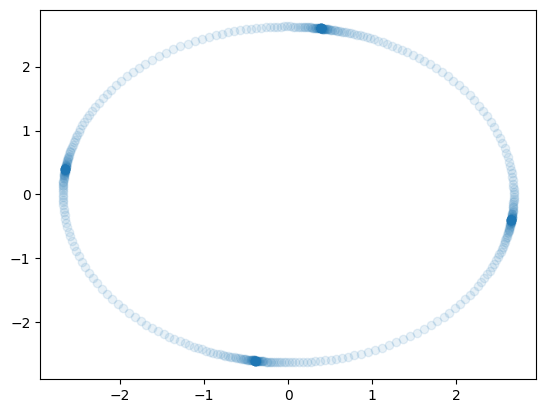

In [86]:
plt.plot(caustic_double_points0, caustic_double_points1, 'o', alpha=0.1)
plt.show()

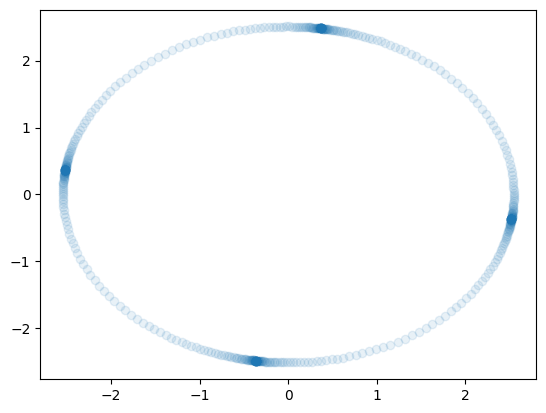

In [67]:
plt.plot(caustic_double_points0, caustic_double_points1, 'o', alpha=0.1)
plt.show()

In [62]:
area/np.pi

3.336438100537854

In [3]:
phi_cut_epl_shear(0.036, -0.018, 2.85, 0.09302973080191373, -0.029833840860278404)

NameError: name 'phi_cut_epl_shear' is not defined

In [1]:
from ler.lens_galaxy_population import OpticalDepth
import numpy as np

In [2]:
od1 = OpticalDepth(
    npool=6,
    optical_depth_function='optical_depth_EPL_Shear_hemanta',
    sampler_priors=dict(
        velocity_dispersion='velocity_dispersion_bernardi',
        axis_ratio='axis_ratio_rayleigh',
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min=0., vd_max=600.),
        axis_ratio=dict(q_min=0.2, q_max=1.),
    ),
    create_new_interpolator=dict(optical_depth=dict(create_new=False, resolution=5),),
)

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_6.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_6.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_6.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
velocity_dispersion_bernardi interpolator will be loaded from ./interpolator_pickle/velocity_dispersion_bernardi/velocity_dispersion_bernardi_2.pickle
optical_depth_EPL_Shear_hemanta interpolator will be loaded from ./interpolator_pickle/optical_depth_EPL_Shear_hemanta/optical_depth_EPL_Shear_hemanta_0.pickle


In [4]:
od1.strong_lensing_optical_depth(np.array([0.1]))


array([2.21177856e-06])

In [3]:
# size = 1000, time = 9m14s, z=1, od=0.00108, for 500 zs 4.81hrs with 16 cores, 9.6hrs with 8 cores
# size = 5000, time = 45m59s, z=1, od=0.00108, for 500 zs 23.95hrs with 16 cores
od1.optical_depth_multiprocessing(zs=1)

array([0.00108489])

In [7]:
(500/16 * (45*60+59.5))/3600

23.953993055555557

In [6]:
(500/8 * (9*60+14.7))/3600

9.630208333333334

In [4]:
od2 = OpticalDepth(
    npool=6,
    optical_depth_function='optical_depth_SIE_hemanta',
    sampler_priors=dict(
        velocity_dispersion='velocity_dispersion_bernardi',
        axis_ratio='axis_ratio_rayleigh',
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min=0., vd_max=600.),
        axis_ratio=dict(q_min=0.2, q_max=1.),
    ),
    create_new_interpolator=dict(optical_depth=dict(create_new=False, resolution=500),),
)

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_6.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_6.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_6.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
velocity_dispersion_bernardi interpolator will be loaded from ./interpolator_pickle/velocity_dispersion_bernardi/velocity_dispersion_bernardi_2.pickle
optical_depth_SIE_hemanta interpolator will be loaded from ./interpolator_pickle/optical_depth_SIE_hemanta/optical_depth_SIE_hemanta_3.pickle


In [5]:
od2.strong_lensing_optical_depth(np.array([1]))

array([0.00040864])

In [10]:
from ler.lens_galaxy_population import OpticalDepth
import numpy as np
od3 = OpticalDepth()

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_6.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_6.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_6.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
velocity_dispersion_bernardi interpolator will be loaded from ./interpolator_pickle/velocity_dispersion_bernardi/velocity_dispersion_bernardi_2.pickle
optical_depth_SIE_hemanta interpolator will be loaded from ./interpolator_pickle/optical_depth_SIE_hemanta/optical_depth_SIE_hemanta_3.pickle


In [12]:
#from ler.utils import  cubic_spline_interpolator

input_ = od3.optical_depth_setter
cubic_spline_interpolator(np.array([0.1]), input_[0], input_[1])

array([8.29191305e-07])

In [16]:
821-230

591

In [27]:
import numpy as np
from numba import njit
batch_size = 10000
size = 25000
samples = np.zeros(size)
batch_size = min(batch_size, size)
n_batches = int(np.ceil(size / batch_size))

In [106]:

def random_norm_with_lim(size, loc, scale, low, high, batch_size=10000):

    samples = np.ones(size)
    batch_size = min(batch_size, size)

    idx0 = 0
    idx1 = 0
    #print(idx0, idx1, size)
    while idx1<size:
        sample = np.random.normal(loc, scale, size=batch_size)
        sample = sample[(sample > low) & (sample < high)]
        len_ = len(sample)
        idx1 = idx0 + len_
        idx2 = len_
        if idx1 > size:
            idx1 = size
            idx2 = size - idx0
        samples[idx0:idx1] = sample[:idx2]
        idx0 += len_
        #print(idx0, idx1, idx2)
        
    return samples

In [93]:
test = random_norm_with_lim(100000, 2., 0.2, 1.1, 2.9, batch_size=25000)

In [94]:
len(test)

100000

In [96]:
@njit
def bounded_normal_sample(mean, std, low, high, size):
    samples = np.empty(size)
    for i in range(size):
        while True:
            sample = np.random.normal(mean, std)
            if low <= sample <= high:
                break
        samples[i] = sample
    return samples

In [103]:
%timeit test = bounded_normal_sample(2., 0.2, 1.1, 2.9, 100000)

1.35 ms ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [107]:
%timeit test = random_norm_with_lim(100000, 2., 0.2, 1.1, 2.9, batch_size=10000)

1.64 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution
import numpy as np

In [2]:
lens = LensGalaxyParameterDistribution()

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_2.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_7.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be loaded from ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_3.pickle
z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_6.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_6.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_6.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
velocity_dispersion_gengamma interpolator will be l

In [6]:
lensed_param = lens.sample_lens_parameters(size=50000)
lensed_param_ = lens.image_properties(lensed_param)

solving lens equations...


100%|███████████████████████████████████████████████████████| 50000/50000 [00:12<00:00, 3957.80it/s]


In [ ]:
def optical_depth_epl2_mp(params):
    """
    Function to calculate the optical depth for SIE lens with velocity dispersion distribution depending on redshift.

    Parameters
    ----------
    params : `list`
        list of parameters
        params[0] = zs (source redshift, float)
        params[1] = no (number density of lens galaxies, float)
        params[2] = vd_inv_cdf (velocity dispersion inverse cdf coefficients and redshift list, list). This vd_inv_cdf(s) of each redshift.
        params[3] = splineVcdz (differential comoving volume spline interpolator coefficients, list)
        params[4] = splineDa (angular diameter distance spline interpolator coefficients and redshift list, list)
        params[5] = idx (index to keep track of the operation, int)
        params[6] = zl_list (list of lens redshifts, list). This use for choosing the right vd_inv_cdf(s) for each lens redshifts.
    
    """

    # integrand
    zs = params[0]
    no = params[1]
    z_list = params[6]
    vd_inv_cdf = params[2]
    vd_inv_cdf_coeff = vd_inv_cdf[:,0]
    vd_list = vd_inv_cdf[0,1]
    vd_sampler = njit(lambda size_,zl_: inverse_transform_sampler(size_, vd_inv_cdf_coeff[np.searchsorted(z_list, zl_)], vd_list))

    splineDa = params[4]
    splineDa_coeff = splineDa[0]
    splineDa_z_list = splineDa[1]
    Da_zs = cubic_spline_interpolator(np.array([zs]), splineDa_coeff, splineDa_z_list)[0]
    Da = njit(lambda zl_: cubic_spline_interpolator(np.array([zl_]), splineDa_coeff, splineDa_z_list)[0])

    splinedVcdz = params[3]
    dVcdz = njit(lambda zl_: cubic_spline_interpolator(np.array([zl_]), splinedVcdz[0], splinedVcdz[1])[0])

    # @njit makes it slower
    def tau_integrand(zl, zs):

        # velocity dispersion #
        size = 5000
        sigma = vd_sampler(size, zl)

        # axis ratio 
        q = axis_ratio_rayleigh(sigma)  # if SIS, q=array of 1.0
        phi = np.random.uniform(0., 2*np.pi, size=size)
        e1, e2 = phi_q2_ellipticity(phi, q)
        gamma = bounded_normal_sample(size=size, mean=2., std=0.2, low=1.1, high=2.7)
        gamma1, gamma2 = np.random.normal(loc=0., scale=0.05,size=(2,size))
        phi_cut = phi_cut_epl_shear(e1, e2, gamma, gamma1, gamma2)

        # einstein radius 
        Dls = (Da_zs*(1+zs) - Da(zl)*(1+zl))/(1+zs)
        theta_E = (
            4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / Da_zs
        )  # Note: km/s for sigma; Dls, Ds are in Mpc

        # cross section 
        cross_section_SIS = theta_E ** 2  # np.pi is ommited
        
        result = phi_cut * cross_section_SIS/4 * no * dVcdz(zl)
        # average
        return np.mean(result)

    return(int(params[5]), quad(tau_integrand, 0, params[0], args=(params[0]))[0])

In [1]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution

In [2]:
lens = LensGalaxyParameterDistribution()

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_2.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_7.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be loaded from ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_3.pickle
z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_6.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_6.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_6.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
velocity_dispersion_gengamma interpolator will be l

In [3]:
sample = lens.sample_lens_parameters(size=5)
sample_ = lens.image_properties(sample)

solving lens equations...


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


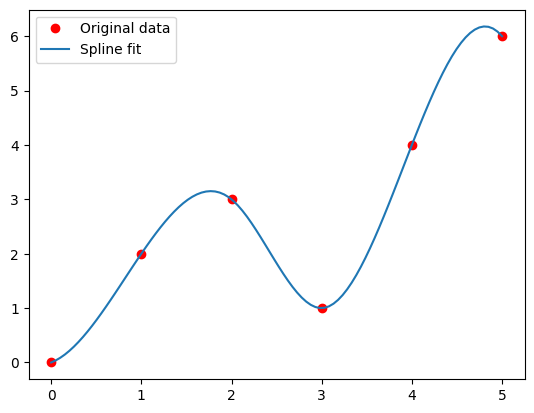

In [7]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# Given data points
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 2, 3, 1, 4, 6])

# Create a UnivariateSpline with a smoothing factor (s)
# s=0 makes it interpolate through all points
spline = UnivariateSpline(x, y, s=0)

# Generate a series of x values for plotting the spline
x_smooth = np.linspace(0, 5, 100)
y_smooth = spline(x_smooth)

# Plotting
plt.plot(x, y, 'ro', label='Original data')
plt.plot(x_smooth, y_smooth, label='Spline fit')
plt.legend()
plt.show()


In [20]:
from ler.lens_galaxy_population import axis_ratio_rayleigh
from ler.utils import interpolator_from_pickle, cubic_spline_interpolator, inverse_transform_sampler
import numpy as np

# Using Padilla and Strauss 2008 distribution for axis ratio
q = np.array([0.04903276402927845, 0.09210526315789469, 0.13596491228070173, 0.20789473684210524, 0.2899703729522482, 0.3230132450331126, 0.35350877192982455, 0.37946148483792264, 0.4219298245614036, 0.4689525967235971, 0.5075026141512723, 0.5226472638550018, 0.5640350877192983, 0.6096491228070177, 0.6500000000000001, 0.6864848379226213, 0.7377192982456142, 0.7787295224817011, 0.8007581038689441, 0.822786685256187, 0.8668438480306729, 0.8973684210526317, 0.9254385964912283])
pdf = np.array([0.04185262687135349, 0.06114520695141845, 0.096997499638376, 0.1932510900336828, 0.39547914337673706, 0.49569751276216234, 0.6154609137685201, 0.7182049959882812, 0.920153741243567, 1.1573982157399754, 1.3353263628106684, 1.413149656448315, 1.5790713532948977, 1.7280185150744938, 1.8132994441344819, 1.8365803753840484, 1.8178662203211204, 1.748929843583365, 1.688182592496342, 1.6274353414093188, 1.4948487090314488, 1.402785526832393, 1.321844068356993])

spline_coeff = np.array([[-1.13194867e+01, -1.13194867e+01,  3.44404745e+01,
         -3.96686201e+01,  2.30621915e+02, -3.59273171e+02,
          3.53212708e+02, -1.06646474e+02, -1.31486225e+02,
          3.33289334e+02, -1.25697131e+03,  2.53766689e+02,
         -9.56054957e+01, -7.21671411e+01,  1.35742014e+02,
         -3.85397370e+01, -6.64152143e+01,  4.50531295e+02,
         -2.26201383e+02,  6.89204235e+01,  7.25836911e+00,
          7.25836911e+00],
        [ 5.72228961e+00,  4.25961387e+00,  2.77020773e+00,
          1.02020996e+01,  4.34617928e-01,  2.32958493e+01,
         -9.57282464e+00,  1.79276593e+01,  4.34036324e+00,
         -1.42081772e+01,  2.43367517e+01, -3.27724187e+01,
         -1.26386557e+00, -1.43467229e+01, -2.30827452e+01,
         -8.22516909e+00, -1.41488570e+01, -2.23199655e+01,
          7.45373043e+00, -7.49495626e+00,  1.61435868e+00,
          2.27903454e+00],
        [ 2.22436518e-01,  6.52382047e-01,  9.60707556e-01,
          1.89380335e+00,  2.76681870e+00,  3.55094150e+00,
          3.96943236e+00,  4.18626299e+00,  5.13194894e+00,
          4.66793697e+00,  5.05839369e+00,  4.93063847e+00,
          3.52195073e+00,  2.80988880e+00,  1.29957693e+00,
          1.57312752e-01, -9.89008399e-01, -2.48460298e+00,
         -2.81208505e+00, -2.81299320e+00, -3.07207564e+00,
         -2.95323148e+00],
        [ 4.18526269e-02,  6.11452070e-02,  9.69974996e-02,
          1.93251090e-01,  3.95479143e-01,  4.95697513e-01,
          6.15460914e-01,  7.18204996e-01,  9.20153741e-01,
          1.15739822e+00,  1.33532636e+00,  1.41314966e+00,
          1.57907135e+00,  1.72801852e+00,  1.81329944e+00,
          1.83658038e+00,  1.81786622e+00,  1.74892984e+00,
          1.68818259e+00,  1.62743534e+00,  1.49484871e+00,
          1.40278553e+00]])

In [7]:
axis_ratio_pdf_spline = interpolator_from_pickle(
    param_dict_given = dict(parameter="axis_ratio", pdf="Padilla and Strauss 2008 distribution for axis ratio"),
    directory="./interpolator_pickle",
    sub_directory="axis_ratio",
    name="axis_ratio",
    x = q,
    pdf_func=None,
    y=pdf,
    conditioned_y=None,
    dimension=1,
    category="function",
    create_new=True,
)

axis_ratio interpolator will be generated at ./interpolator_pickle/axis_ratio/axis_ratio_0.pickle


In [16]:
od1.c_n_i["axis_ratio"]["resolution"]


KeyError: 'axis_ratio'

In [19]:
q_min = 0.2
q_max = 1.
resolution = 500
create_new = False
q_array = np.linspace(q_min, q_max, resolution)
pdf_array = cubic_spline_interpolator(q_array, axis_ratio_pdf_spline[0], axis_ratio_pdf_spline[1])

q_inv_cdf = interpolator_from_pickle(
    param_dict_given = dict(parameter="axis_ratio", pdf="Padilla and Strauss 2008 distribution for axis ratio", q_min=q_min, q_max=q_max, resolution=resolution),
    directory="./interpolator_pickle",
    sub_directory="axis_ratio",
    name="axis_ratio",
    x = q_array,
    pdf_func=None,
    y=pdf_array,
    conditioned_y=None,
    dimension=1,
    category="inv_cdf",
    create_new=create_new,
)


axis_ratio interpolator will be loaded from ./interpolator_pickle/axis_ratio/axis_ratio_1.pickle


In [27]:
q_ = inverse_transform_sampler(50000, q_inv_cdf[0], q_inv_cdf[1])

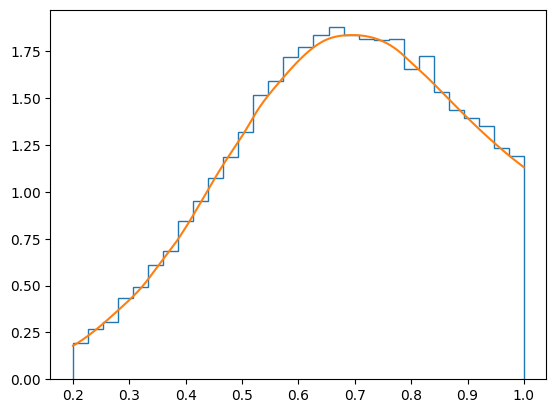

In [28]:
import matplotlib.pyplot as plt
plt.hist(q_, bins=30, density=True, histtype='step')
plt.plot(q_array, pdf_array)
plt.show()

In [ ]:
array([[-1.13194867e+01, -1.13194867e+01,  3.44404745e+01,
         -3.96686201e+01,  2.30621915e+02, -3.59273171e+02,
          3.53212708e+02, -1.06646474e+02, -1.31486225e+02,
          3.33289334e+02, -1.25697131e+03,  2.53766689e+02,
         -9.56054957e+01, -7.21671411e+01,  1.35742014e+02,
         -3.85397370e+01, -6.64152143e+01,  4.50531295e+02,
         -2.26201383e+02,  6.89204235e+01,  7.25836911e+00,
          7.25836911e+00],
        [ 5.72228961e+00,  4.25961387e+00,  2.77020773e+00,
          1.02020996e+01,  4.34617928e-01,  2.32958493e+01,
         -9.57282464e+00,  1.79276593e+01,  4.34036324e+00,
         -1.42081772e+01,  2.43367517e+01, -3.27724187e+01,
         -1.26386557e+00, -1.43467229e+01, -2.30827452e+01,
         -8.22516909e+00, -1.41488570e+01, -2.23199655e+01,
          7.45373043e+00, -7.49495626e+00,  1.61435868e+00,
          2.27903454e+00],
        [ 2.22436518e-01,  6.52382047e-01,  9.60707556e-01,
          1.89380335e+00,  2.76681870e+00,  3.55094150e+00,
          3.96943236e+00,  4.18626299e+00,  5.13194894e+00,
          4.66793697e+00,  5.05839369e+00,  4.93063847e+00,
          3.52195073e+00,  2.80988880e+00,  1.29957693e+00,
          1.57312752e-01, -9.89008399e-01, -2.48460298e+00,
         -2.81208505e+00, -2.81299320e+00, -3.07207564e+00,
         -2.95323148e+00],
        [ 4.18526269e-02,  6.11452070e-02,  9.69974996e-02,
          1.93251090e-01,  3.95479143e-01,  4.95697513e-01,
          6.15460914e-01,  7.18204996e-01,  9.20153741e-01,
          1.15739822e+00,  1.33532636e+00,  1.41314966e+00,
          1.57907135e+00,  1.72801852e+00,  1.81329944e+00,
          1.83658038e+00,  1.81786622e+00,  1.74892984e+00,
          1.68818259e+00,  1.62743534e+00,  1.49484871e+00,
          1.40278553e+00]])

In [ ]:
# plot
import matplotlib.pyplot as plt
plt.plot(q, pdf, 'o')
plt.hist(axis_ratio_rayleigh(10000), bins=50, density=True)
plt.show()

In [1]:
from ler.lens_galaxy_population import OpticalDepth
import numpy as np
from multiprocessing import Pool
from ler.utils import append_json

In [13]:
od1 = OpticalDepth(
    npool=6,
    optical_depth_function='optical_depth_EPL_Shear_hemanta',
    sampler_priors=dict(
        velocity_dispersion='velocity_dispersion_bernardi',
        axis_ratio='axis_ratio_rayleigh',
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min=0., vd_max=600.),
        axis_ratio=dict(q_min=0.2, q_max=1.),
    ),
    create_new_interpolator=dict(optical_depth=dict(create_new=False, resolution=5),),
)

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_6.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_6.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_6.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
velocity_dispersion_bernardi interpolator will be loaded from ./interpolator_pickle/velocity_dispersion_bernardi/velocity_dispersion_bernardi_2.pickle
optical_depth_EPL_Shear_hemanta interpolator will be loaded from ./interpolator_pickle/optical_depth_EPL_Shear_hemanta/optical_depth_EPL_Shear_hemanta_0.pickle


In [3]:
od1 = OpticalDepth(
    npool=6,
    optical_depth_function='optical_depth_SIE_hemanta',
    sampler_priors=dict(
        velocity_dispersion='velocity_dispersion_bernardi',
        axis_ratio='axis_ratio_padilla_strauss',
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min=0., vd_max=600.),
        axis_ratio=dict(q_min=0.2, q_max=1.),
    ),
    create_new_interpolator=dict(optical_depth=dict(create_new=False, resolution=500),),
)

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_6.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_6.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_6.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
velocity_dispersion_bernardi interpolator will be loaded from ./interpolator_pickle/velocity_dispersion_bernardi/velocity_dispersion_bernardi_4.pickle
axis_ratio_spline_coeff interpolator will be generated at ./interpolator_pickle/axis_ratio/axis_ratio_spline_coeff_0.pickle
axis_ratio interpolator will be loaded from ./interpolator_pickle/axis_ratio/axis_ratio_1.pickle
optical_depth_SIE_hemanta interpolator will be generated at ./interpolator_pickle/optical_depth_SIE_hemanta/optical_depth_SIE_hemanta_10.pickle
axis_ratio_spli

In [3]:
od1.sample_axis_ratio = "axis_ratio_padilla_strauss"

axis_ratio_spline_coeff interpolator will be generated at ./interpolator_pickle/axis_ratio/axis_ratio_spline_coeff_0.pickle
axis_ratio interpolator will be loaded from ./interpolator_pickle/axis_ratio/axis_ratio_1.pickle


In [4]:
od1.sample_axis_ratio(np.ones(10)*161.)

array([0.68047781, 0.54472556, 0.61056126, 0.57598658, 0.5061438 ,
       0.973479  , 0.27623901, 0.8309032 , 0.90521506, 0.48663484])

In [5]:
od1.sample_axis_ratio?

Type:        property
String form: <property object at 0x16e331940>
Docstring:  
Function to sample axis ratio from rayleigh distribution with given velocity dispersion.

Parameters
----------
sigma : `numpy.ndarray` (1D array of floats)
    velocity dispersion of the lens galaxy

Returns
-------
q : `numpy.ndarray` (1D array of floats)
    axis ratio of the lens galaxy

Examples
--------
>>> from ler.lens_galaxy_population import OpticalDepth
>>> od = OpticalDepth()
>>> print(od.sample_axis_ratio(sigma=200.))

In [3]:
od1.axis_ratio_padilla_strauss?

Signature:
od1.axis_ratio_padilla_strauss(
    size=1000,
    q_min=0.2,
    q_max=1.0,
    get_attribute=False,
    param=None,
    **kwargs,
)
Docstring:
Function to sample axis ratio using Padilla and Strauss 2008 distribution for axis ratio

Parameters
----------
size : `int`
    sample size
q_min, q_max : `float`
    minimum and maximum axis ratio
get_attribute : `bool`
    if True, returns a function that can be used to sample axis ratio

Returns
-------
q : `float: array`
    axis ratio of the lens galaxy

Examples
--------
>>> from ler.lens_galaxy_population import OpticalDepth
>>> od = OpticalDepth(sampler_priors=dict(axis_ratio="axis_ratio_padilla_strauss"))
>>> print(od.sample_axis_ratio(size=10))
File:      ~/phd/mypackages/ler/ler/lens_galaxy_population/optical_depth.py
Type:      method

In [3]:
# initialize 'optical_depth.json'
append_json('optical_depth.json', dict(zs=[], tau=[],), replace=True)

In [6]:
from ler.lens_galaxy_population import test

def optical_depth_multiprocessing(zs, resume=False, json_file='optical_depth.json'):
        
        zs = np.array([zs]).reshape(-1)
        # open json file
        if resume:
            with open(json_file, 'r') as f:
                data = json.load(f)
            zs_old = np.array(data['zs'])
            # remove zs that already calculated
            idx = np.isin(zs, zs_old, invert=True)
            zs = zs[idx]
            # if all zs are already calculated, return
            if len(zs) == 0:
                return
             
        no = 8*1e-3*od1.cosmo.h**3
        vd_inv_cdf = od1.vd_inv_cdf
        splinedVcdz = od1.splinedVcdz
        splineDa = od1.splineDa
        idx = np.arange(len(zs))
        try:
            zl_list = od1.zl_list
            input_params = [(zs[i], no, vd_inv_cdf, splinedVcdz, splineDa, idx[i], zl_list) for i in range(len(zs))]
        except:
            input_params = [(zs[i], no, vd_inv_cdf, splinedVcdz, splineDa, idx[i]) for i in range(len(zs))]

        # Create a pool of workers and parallelize the integration
        with Pool(processes=od1.npool) as pool:
            result = list(pool.map(test, input_params))

        result = np.array(result)
        tau_list = result[:,1][np.array(result[:,0], dtype=int)]

        return tau_list

In [7]:
optical_depth_multiprocessing(zs=np.geomspace(0.1, 10, 10), resume=False, json_file='optical_depth.json')

array([8.30789896e-07, 3.67522534e-06, 1.56546754e-05, 6.28720678e-05,
       2.27056698e-04, 7.00774432e-04, 1.77982590e-03, 3.67979656e-03,
       6.35472954e-03, 9.53005861e-03])